# CS 4320 Final Project

In [330]:
import pandas as pd
from datetime import date, timedelta
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
# import plotly.express as px

In [331]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import scipy.stats
import pylab

import sklearn
import calendar as cal
from sklearn.pipeline import Pipeline
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn.pipeline import Pipeline
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf, acf

from sklearn.metrics import make_scorer, r2_score, mean_squared_error
import statsmodels.tsa as tsa
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Read in data
---

In [332]:
train = pd.read_csv("train.csv", parse_dates=['date'])
test = pd.read_csv("test.csv", parse_dates=['date'])
oil = pd.read_csv("oil.csv", parse_dates=['date'])
holidays_events = pd.read_csv("holidays_events.csv", parse_dates=['date'])
transactions = pd.read_csv("transactions.csv", parse_dates=['date'])
stores = pd.read_csv("stores.csv")

In [333]:
#add other data sets to training set
train_ext = train.merge(stores, on='store_nbr', how='left')
train_ext['date'] = train_ext['date'].astype('datetime64[ns]')
transactions['date'] = transactions['date'].astype('datetime64[ns]')
train_ext = train_ext.merge(transactions, on=['date', 'store_nbr'], how='left')
train_ext['date'] = train_ext.date.dt.to_period('D')
# transactions['date'] = transactions.date.dt.to_period('D')
# train_ext = train_ext.rename(columns={"type": "store_type"})
train_ext = train_ext.set_index(['store_nbr', 'family', 'date']).sort_index()

## Pre Analysis of sales/transaction trends
---

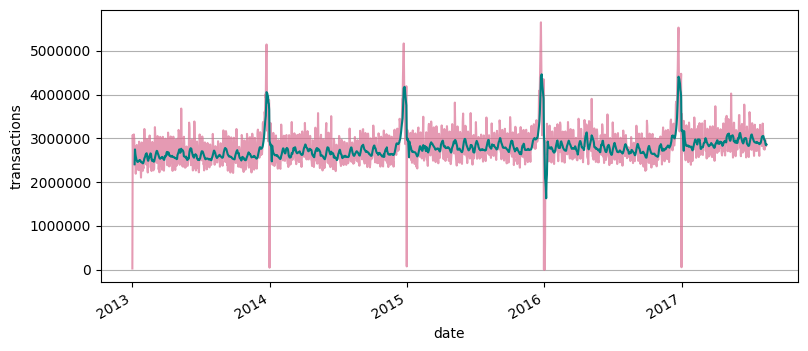

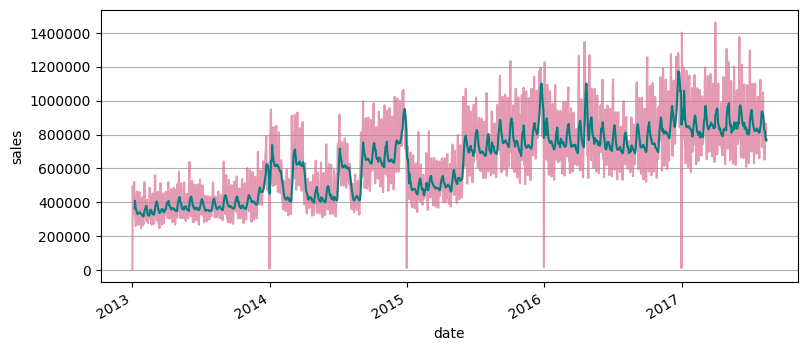

In [334]:
#weekly average of sales
sales_data=train.groupby('date').agg({'sales':'sum'}).reset_index()
sales_data['sales_average'] = sales_data['sales'].rolling(7).mean()

sales_data_reg = sales_data.set_index(['date']).sort_index().drop('sales_average', axis=1)
sales_data_avg = sales_data.set_index(['date']).sort_index().drop('sales', axis=1)


#weekly average of transactions
trans_data=train_ext.groupby('date').agg({'transactions':'sum'}).reset_index()
trans_data['transactions_average'] = trans_data['transactions'].rolling(7).mean()
trans_data['date'] = trans_data['date'].dt.to_timestamp()

trans_data_reg = trans_data.set_index(['date']).sort_index().drop('transactions_average', axis=1)
trans_data_avg = trans_data.set_index(['date']).sort_index().drop('transactions', axis=1)



# plot the roc curve for the model
f = plt.figure()
f.set_figwidth(9)
f.set_figheight(4)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(visible=True, which='major', axis='y')
plt.plot(trans_data_reg, 'palevioletred', alpha=0.7)
plt.plot(trans_data_avg, 'teal')
plt.gcf().autofmt_xdate()
plt.xlabel('date')
plt.ylabel('transactions')
plt.show()


f = plt.figure()
f.set_figwidth(9)
f.set_figheight(4)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(visible=True, which='major', axis='y')
plt.plot(sales_data_reg, 'palevioletred', alpha=0.7)
plt.plot(sales_data_avg, 'teal')
plt.gcf().autofmt_xdate()
plt.xlabel('date')
plt.ylabel('sales')
plt.show()

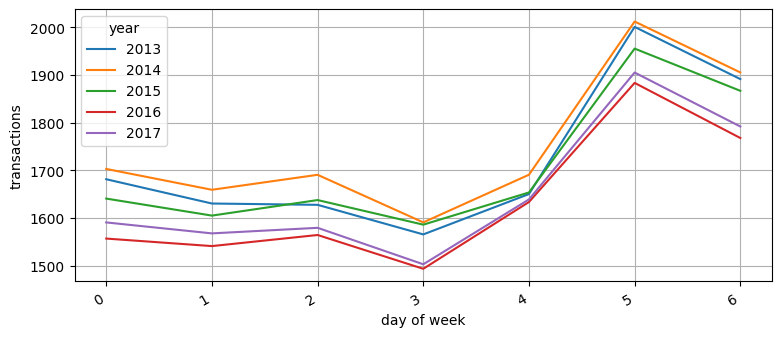

In [335]:
temp=transactions.copy()
temp['year']=temp.date.dt.year
temp['month']=temp.date.dt.month
temp['dayofweek']=temp.date.dt.dayofweek
temp=temp.groupby(['year','dayofweek'])['transactions'].mean().reset_index()
# px.line(temp.reset_index(),x='dayofweek',y='transactions',color='year')
temp = temp.pivot(index='dayofweek', columns='year', values='transactions')

temp.plot(figsize=(9,4), grid=True)
plt.gcf().autofmt_xdate()
plt.xlabel('day of week')
plt.ylabel('transactions')
plt.show()

In [336]:
print(train.head())
x,y=train.shape
print("\nNo of rows in training data initially: ",x)
print("No of cols in training data initially: ",y)

   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

No of rows in training data initially:  3000888
No of cols in training data initially:  6


In [337]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


## Training Preprocessing
---

In [338]:
calendar = pd.DataFrame(pd.date_range(train.date.min(), test.date.max()), columns=['date'])


calendar['date'] = calendar['date'].astype('datetime64[ns]')
calendar['year'] = calendar['date'].dt.year
calendar['month'] = calendar['date'].dt.month
calendar['week'] = calendar['date'].dt.isocalendar().week
calendar['quarter'] = calendar['date'].dt.quarter
# calendar['day_name'] = calendar['date'].dt.day_name()
calendar = calendar.set_index('date').sort_index()
calendar.index = calendar.index.to_period('D')
calendar['weekday'] = calendar.index.dayofweek 
calendar.head(30)

year  month  week  quarter  weekday
date                                           
2013-01-01  2013      1     1        1        1
2013-01-02  2013      1     1        1        2
2013-01-03  2013      1     1        1        3
2013-01-04  2013      1     1        1        4
2013-01-05  2013      1     1        1        5
2013-01-06  2013      1     1        1        6
2013-01-07  2013      1     2        1        0
2013-01-08  2013      1     2        1        1
2013-01-09  2013      1     2        1        2
2013-01-10  2013      1     2        1        3
2013-01-11  2013      1     2        1        4
2013-01-12  2013      1     2        1        5
2013-01-13  2013      1     2        1        6
2013-01-14  2013      1     3        1        0
2013-01-15  2013      1     3        1        1
2013-01-16  2013      1     3        1        2
2013-01-17  2013      1     3        1        3
2013-01-18  2013      1     3        1        4
2013-01-19  2013      1     3        1        5
2013-01-20  2013      1     3        1        6
2013-01-21  2013      1     4        1        0
2013-01-22  2013      1     4        1        1
2013-01-23  2013      1     4        1        2
2013-01-24  2013      1     4        1        3
2013-01-25  2013      1     4        1        4
2013-01-26  2013      1     4        1        5
2013-01-27  2013      1     4        1        6
2013-01-28  2013      1     5        1        0
2013-01-29  2013      1     5        1        1
2013-01-30  2013      1     5        1        2

In [339]:
holidays_events = holidays_events[holidays_events.locale=='National']
holidays_events = holidays_events.set_index('date').sort_index()
holidays_events.index = holidays_events.index.to_period('D')
# keep only one event per day
holidays_events = holidays_events.groupby(holidays_events.index).first()
holidays_events.drop(columns=['locale', 'locale_name', 'description'], inplace=True)
holidays_events.head()

type  transferred
date                             
2012-08-10   Holiday        False
2012-10-09   Holiday         True
2012-10-12  Transfer        False
2012-11-02   Holiday        False
2012-11-03   Holiday        False

In [340]:
def compute_workdays(df):
    df['workday'] = True
    df.loc[df['weekday'] > 4, 'workday'] = False
    df.loc[df.type=='Bridge', 'workday'] = False
    df.loc[df.type=='Work Day', 'workday'] = True
    df.loc[df.type=='Transfer', 'workday'] = False
    df.loc[(df.type=='Holiday')&(df.transferred==False), 'workday'] = False
    df.loc[(df.type=='Holiday')&(df.transferred==True ), 'workday'] = True
    return df

In [341]:
calendar = calendar.merge(holidays_events, how='left', left_index=True, right_index=True)
calendar = compute_workdays(calendar)
calendar['workday'] = calendar['workday'] * 1
calendar.drop(columns=['transferred'], inplace=True)
calendar.reset_index()
calendar.head(10)

year  month  week  quarter  weekday      type  workday
date                                                              
2013-01-01  2013      1     1        1        1   Holiday        0
2013-01-02  2013      1     1        1        2       NaN        1
2013-01-03  2013      1     1        1        3       NaN        1
2013-01-04  2013      1     1        1        4       NaN        1
2013-01-05  2013      1     1        1        5  Work Day        1
2013-01-06  2013      1     1        1        6       NaN        0
2013-01-07  2013      1     2        1        0       NaN        1
2013-01-08  2013      1     2        1        1       NaN        1
2013-01-09  2013      1     2        1        2       NaN        1
2013-01-10  2013      1     2        1        3       NaN        1

In [342]:
train_ext = train_ext.merge(calendar, how='left', left_index=True, right_index=True)
train_ext = train_ext.rename(columns={"type_x": "store_type", "type_y": "day_type"})
train_ext.head(10)

id  sales  onpromotion   city      state  \
store_nbr family     date                                                      
1         AUTOMOTIVE 2013-01-01      0    0.0            0  Quito  Pichincha   
                     2013-01-02   1782    2.0            0  Quito  Pichincha   
                     2013-01-03   3564    3.0            0  Quito  Pichincha   
                     2013-01-04   5346    3.0            0  Quito  Pichincha   
                     2013-01-05   7128    5.0            0  Quito  Pichincha   
                     2013-01-06   8910    2.0            0  Quito  Pichincha   
                     2013-01-07  10692    0.0            0  Quito  Pichincha   
                     2013-01-08  12474    2.0            0  Quito  Pichincha   
                     2013-01-09  14256    2.0            0  Quito  Pichincha   
                     2013-01-10  16038    2.0            0  Quito  Pichincha   

                                store_type  cluster  transactions  year  \
store_nbr family     date                                                 
1         AUTOMOTIVE 2013-01-01          D       13           NaN  2013   
                     2013-01-02          D       13        2111.0  2013   
                     2013-01-03          D       13        1833.0  2013   
                     2013-01-04          D       13        1863.0  2013   
                     2013-01-05          D       13        1509.0  2013   
                     2013-01-06          D       13         520.0  2013   
                     2013-01-07          D       13        1807.0  2013   
                     2013-01-08          D       13        1869.0  2013   
                     2013-01-09          D       13        1910.0  2013   
                     2013-01-10          D       13        1679.0  2013   

                                 month  week  quarter  weekday  day_type  \
store_nbr family     date                                                  
1         AUTOMOTIVE 2013-01-01      1     1        1        1   Holiday   
                     2013-01-02      1     1        1        2       NaN   
                     2013-01-03      1     1        1        3       NaN   
                     2013-01-04      1     1        1        4       NaN   
                     2013-01-05      1     1        1        5  Work Day   
                     2013-01-06      1     1        1        6       NaN   
                     2013-01-07      1     2        1        0       NaN   
                     2013-01-08      1     2        1        1       NaN   
                     2013-01-09      1     2        1        2       NaN   
                     2013-01-10      1     2        1        3       NaN   

                                 workday  
store_nbr family     date                 
1         AUTOMOTIVE 2013-01-01        0  
                     2013-01-02        1  
                     2013-01-03        1  
                     2013-01-04        1  
                     2013-01-05        1  
                     2013-01-06        0  
                     2013-01-07        1  
                     2013-01-08        1  
                     2013-01-09        1  
                     2013-01-10        1

## Fitting and tuning Models
---

## Test Preprocessing
---

## Predictions and Output
___

## Old Code
---

In [ ]:
training_data_df = pd.read_csv("train.csv")
training_data_df['date'] = pd.to_datetime(training_data_df['date'], format='%Y-%m-%d')

#remove entries bewtween the day before the earthquake struck and 3 months after.
training_data_df = training_data_df.loc[(training_data_df['date'] < '2016-04-15')
                     | (training_data_df['date'] > '2016-05-15')]
                     
id_col = training_data_df[["id"]]
target = "sales"
y_data = training_data_df[[target]]
X_data = training_data_df.drop(target, axis=1)
X_data.head()

id       date  store_nbr      family  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE            0
1   1 2013-01-01          1   BABY CARE            0
2   2 2013-01-01          1      BEAUTY            0
3   3 2013-01-01          1   BEVERAGES            0
4   4 2013-01-01          1       BOOKS            0

In [ ]:
x_test = pd.read_csv("test.csv")
id_col = x_test[["id"]]
x_test.head()

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

In [ ]:
numeric_features = ["store_nbr", "onpromotion"]
categorical_features = ["family"]
drop_features = ["id", "date"]
transformer = make_column_transformer((StandardScaler(), numeric_features), (OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features), ("drop", drop_features), n_jobs=-1)

In [ ]:
pipeline = make_pipeline(transformer)
pipeline.fit_transform(X_data, y_data)

array([[-1.70026736, -0.21342588,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.70026736, -0.21342588,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.70026736, -0.21342588,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.1869791 , 12.18646359,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-1.1869791 ,  0.45683842,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.1869791 , -0.21342588,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

## Linear Regressor Method

In [ ]:
regressor = LinearRegression()
regressor.fit(pipeline.transform(X_data), y_data)

KeyboardInterrupt: 

In [ ]:
results = regressor.predict(pipeline.transform(x_test))
id_column = []
for i in range(len(results)):
    id_column.append(3000888 + i)

results = pd.DataFrame(results, columns=['sales'])
results.insert(0, 'id', id_column, True)

# print(results.reset_index().to_string(index=False))
# results.index.name = None

# results.columns.name = {'id' : 'sales'}

# df.index = ['Row_1', 'Row_2', 'Row_3', 'Row_4']
# results.columns.names = {'id' : 'sales'}
# results.index.names = ['id']
#results.drop('')
#results.rename(columns={'':'id'}, inplace=True)#.columns = ["id", "sales"]#.rename(columns={0:'id', 1:'sales'}) # .replace(0, id_col)
results.to_csv('predictions2.csv', index=False)
results.head()

id         sales
0      3000888    -70.453857
1      3000889    -76.009644
2      3000890    -34.333374
3      3000891   2490.097168
4      3000892    -75.137451
5      3000893    553.263550
6      3000894    -67.947266
7      3000895   1342.384399
8      3000896   1356.895020
9      3000897    416.178711
10     3000898     74.810669
11     3000899     73.522949
12     3000900   4524.698853
13     3000901    -55.116943
14     3000902    -74.287476
15     3000903    -25.968384
16     3000904     52.075562
17     3000905    -74.488892
18     3000906    251.491577
19     3000907    -68.146973
20     3000908    240.988525
21     3000909     29.425049
22     3000910    175.747559
23     3000911    -72.271729
24     3000912    202.496216
25     3000913    492.683350
26     3000914    -71.856812
27     3000915    -69.321777
28     3000916    226.771118
29     3000917     13.735962
30     3000918   6020.788208
31     3000919    198.672241
32     3000920    -61.290161
33     3000921    -44.969849
34     3000922    -50.525635
35     3000923     -8.849365
36     3000924   2964.859009
37     3000925    -49.653442
38     3000926    637.348999
39     3000927    -42.463257
40     3000928   1465.537476
41     3000929   2573.941895
42     3000930    441.662720
43     3000931    100.294678
44     3000932     99.006958
45     3000933   5175.265015
46     3000934    -29.632935
47     3000935    -48.803467
48     3000936     -0.484375
49     3000937     77.559570
50     3000938    -49.004883
51     3000939    374.644653
52     3000940    -42.662964
53     3000941    266.472534
54     3000942     54.909058
55     3000943    220.765381
56     3000944    -46.787720
57     3000945    227.980225
58     3000946    537.701172
59     3000947    -46.372803
60     3000948    -43.837769
61     3000949    252.255127
62     3000950     39.219971
63     3000951   5538.392944
64     3000952    224.156128
65     3000953    -35.806152
66     3000954    -42.138306
67     3000955    -47.694092
68     3000956     -6.017822
69     3000957   3143.494873
70     3000958    -46.821899
71     3000959    659.714355
72     3000960    -39.631714
73     3000961   1566.038086
74     3000962   3338.592285
75     3000963    444.494263
76     3000964    103.126221
77     3000965    101.838501
78     3000966   5295.299561
79     3000967    -26.801392
80     3000968    -45.971924
81     3000969     41.414795
82     3000970     80.391113
83     3000971    -46.173340
84     3000972    357.942383
85     3000973    -39.831421
86     3000974    269.304077
87     3000975     18.672974
88     3000976    184.529175
89     3000977    -43.956177
90     3000978    230.811768
91     3000979    520.998901
92     3000980    -43.541260
93     3000981    -21.472412
94     3000982    255.086670
95     3000983     42.051514
96     3000984   4232.458618
97     3000985    226.987671
98     3000986    -32.974609
99     3000987    -39.306763
100    3000988    -44.862549
101    3000989     -3.186279
102    3000990   2872.852905
103    3000991    -43.990356
104    3000992    682.079712
105    3000993    -36.800171
106    3000994   1451.666748
107    3000995   2755.409302
108    3000996    447.325806
109    3000997    105.957764
110    3000998    104.670044
111    3000999   5005.123779
112    3001000    -23.969849
113    3001001    -43.140381
114    3001002      5.178711
115    3001003     83.222656
116    3001004    -43.341797
117    3001005    380.307739
118    3001006    -36.999878
119    3001007    272.135620
120    3001008     60.572144
121    3001009    206.894653
122    3001010    -41.124634
123    3001011    233.643311
124    3001012    465.229004
125    3001013    -40.709717
126    3001014    -38.174683
127    3001015    277.452026
128    3001016     44.883057
129    3001017   5329.183960
130    3001018    229.819214
131    3001019    -30.143066
132    3001020    -36.475220
133    3001021    -42.031006
134    3001022     -0.354736
135    3001023   2778.015381
136    3001024    -41.158813
137    300